In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import mpmp.config as cfg
import mpmp.utilities.analysis_utilities as au
import mpmp.utilities.survival_utilities as su
import mpmp.utilities.plot_utilities as plu

%load_ext autoreload
%autoreload 2

In [2]:
# significance cutoff, after FDR correction
SIG_ALPHA = 0.05

# if True, save figures to images directory
# SAVE_FIGS = True

# set results directory
me_results_dir = Path(cfg.repo_root,
                      '06_predict_survival',
                      'results_extended_alphas')

# set list of PCA component numbers to look for
pcs_list = [10, 100, 500, 1000, 5000]

In [3]:
me_data_count_df = []

for n_dim in pcs_list:
    # load results into a single dataframe
    me_pcs_dir = Path(me_results_dir, 'results_{}_pca'.format(n_dim))
    me_results_df = su.load_survival_results(me_pcs_dir)
    me_results_df.rename(columns={'identifier': 'cancer_type',
                                  'fold_no': 'fold'}, inplace=True)
    
    me_count_df = (me_results_df[me_results_df.data_type == 'test']
        .groupby(['cancer_type', 'training_data'])
        .count()
    )
    problem_df = me_count_df[me_count_df['cindex'] != 16].copy()
    drop_cancer_types = problem_df.index.get_level_values(0).unique().values
    
    me_all_results_df = au.compare_all_data_types(
        me_results_df[~me_results_df.cancer_type.isin(drop_cancer_types)],
        SIG_ALPHA,
        identifier='cancer_type',
        metric='cindex')
    
    print(n_dim)
    num_reject = me_all_results_df.groupby(['training_data']).sum().reject_null
    num_total = me_all_results_df.groupby(['training_data']).count().reject_null
    
    dim_count_df = (
            pd.DataFrame(num_reject).rename(columns={'reject_null': 'num_reject'})
        .merge(
            pd.DataFrame(num_total).rename(columns={'reject_null': 'num_total'})
        , left_index=True, right_index=True)
    )
    dim_count_df['n_dim'] = n_dim
    dim_count_df['ratio'] = dim_count_df.num_reject / dim_count_df.num_total
    me_data_count_df.append(dim_count_df)
    
me_data_count_df = pd.concat(me_data_count_df).reset_index()
me_data_count_df.head(10)

10
100
500
1000
5000


,training_data,num_reject,num_total,n_dim,ratio
0,expression,17,30,10,0.566667
1,me_27k,7,30,10,0.233333
2,me_450k,7,30,10,0.233333
3,expression,10,30,100,0.333333
4,me_27k,15,30,100,0.500000
5,me_450k,12,30,100,0.400000
6,expression,14,26,500,0.538462
7,me_27k,7,26,500,0.269231
8,me_450k,10,26,500,0.384615
9,expression,12,23,1000,0.521739


Text(0.5, 1.0, 'Well-predicted/total ratio vs. PC count')

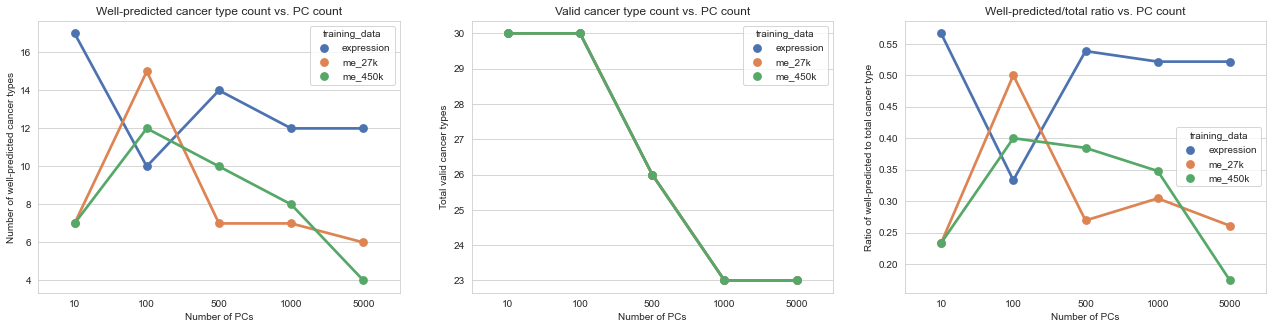

In [4]:
sns.set({'figure.figsize': (22, 5)})
sns.set_style('whitegrid')
fig, axarr = plt.subplots(1, 3)

sns.pointplot(data=me_data_count_df, x='n_dim', y='num_reject', hue='training_data', ax=axarr[0])
axarr[0].set_xlabel('Number of PCs')
axarr[0].set_ylabel('Number of well-predicted cancer types')
axarr[0].set_title('Well-predicted cancer type count vs. PC count')

sns.pointplot(data=me_data_count_df, x='n_dim', y='num_total', hue='training_data', ax=axarr[1])
axarr[1].set_xlabel('Number of PCs')
axarr[1].set_ylabel('Total valid cancer types')
axarr[1].set_title('Valid cancer type count vs. PC count')

sns.pointplot(data=me_data_count_df, x='n_dim', y='ratio', hue='training_data', ax=axarr[2])
axarr[2].set_xlabel('Number of PCs')
axarr[2].set_ylabel('Ratio of well-predicted to total cancer type')
axarr[2].set_title('Well-predicted/total ratio vs. PC count')